In [1]:
import math
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

from ema_workbench import save_results, load_results
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import clusterer, plotting, Density

#%matplotlib inline
clr_palette = ([sns.color_palette("YlGn", 15)[10],sns.cubehelix_palette(8)[6]])

pydice_folder = "C:/Users/ivart/OneDrive/Bureaublad/Afstuderen/WRR/PyRICE Ivar Tjallingii/PyRICE2020/6_Uncertainty Analysis/model_server"
sys.path.append(pydice_folder)

from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, ScalarOutcome, ArrayOutcome, 
                           Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)

from PyRICE_V8_long_term_uncertainty import PyRICE

from matplotlib import pyplot

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


## get main results with output on principle objectives

In [2]:
experiments_total = pd.read_csv("long_term_uncertainty_experiments_total_complete.csv")

In [3]:
experiments = experiments_total.iloc[:,1:20]
outcomes = experiments_total.iloc[:,20:]

In [4]:
objectives = ["Atmospheric Temperature", "Damages", "Distance to treshold", "Highest climate impact per capita", 
              "Intratemporal impact GINI", "Intratemporal utility GINI", 
              "Lowest income per capita", "Population under treshold","Utility"]

objectives_single = ["Total Aggregated Utility","Intertemporal impact GINI", "Intertemporal utility GINI"]

years = [2065,2105,2205,2305]

objective_total =[]
for objective in objectives:
    for year in years:
        name = objective + " " + str(year)
        objective_total.append(name)
        
for objective in objectives_single:
    objective_total.append(objective)
    
experiments['policy_recoded']=experiments['principle'].astype(str).str[0:4] + "_"+ experiments['policy'] 

In [5]:
outcomes_robust_analysis = outcomes[objective_total]

## Robustness metrics

In [6]:
model = PyRICE(model_specification="EMA",welfare_function="egalitarian")
RICE = Model('RICE', function = model)

In [7]:
from model_outcomes_uncertainty_long_term import get_all_model_outcomes_uncertainty_search

In [8]:
RICE.outcomes = get_all_model_outcomes_uncertainty_search(optimization_formulation = "long_term_robustness")

### Signal to noise ratio

In [9]:
overall_scores = {}
for policy in np.unique(experiments['policy_recoded']):
    scores = {}

    logical = experiments['policy_recoded']==policy

    for outcome in RICE.outcomes:
        value  = outcomes[outcome.name][logical]
        mean = np.mean(value)
        std = np.std(value) 
        if outcome.kind == ScalarOutcome.MAXIMIZE:
            sn_ratio = mean/std
        else:
            sn_ratio = mean*std
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

In [10]:
scores_min_max=(scores-scores.min())/(scores.max()-scores.min())
scores_min_max["average_snr"] = scores_min_max.mean(axis=1)

In [11]:
scores_min_max = scores_min_max.transpose()
scores_min_max = scores_min_max.sort_index()

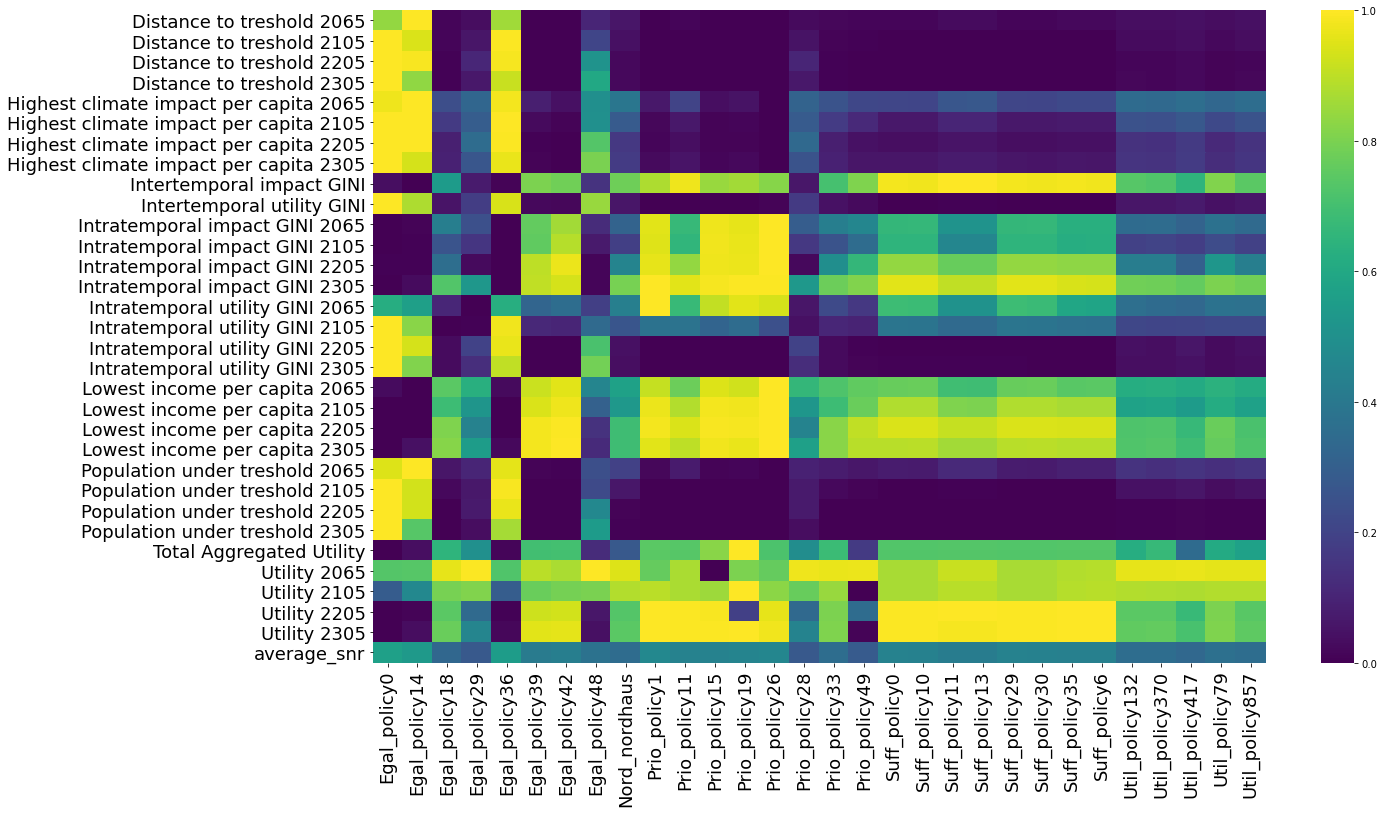

In [12]:
fig, ax = plt.subplots(figsize=(20,12))         
sns.heatmap(scores_min_max, cmap='viridis', annot=False,ax=ax)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)

fig.savefig('robustness_SNR_long_term_heatmap.png', dpi=200,bbox_inches='tight')
plt.show()

### Minimax (Max regret)

In [13]:
#missing policies from saved file -- something wrong in preprocessing stage
experiments['policy'].unique()
experiments['policy_recoded']=experiments['principle'].astype(str).str[0:4] + "_"+ experiments['policy'] 

In [14]:
overall_regret = {}
max_regret = {}
policy_column = experiments['policy_recoded']
for outcome in RICE.outcomes:
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy_recoded'],
                         "scenario":experiments['scenario']})
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row

    if outcome.kind == ScalarOutcome.MINIMIZE:
        outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
    else:
        outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

max_regret = pd.DataFrame(max_regret)

<ipython-input-14-812a71cf8319>:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
<ipython-input-14-812a71cf8319>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()


In [15]:
max_regret_min_max=(max_regret-max_regret.min())/(max_regret.max()-max_regret.min())
max_regret_min_max["average_maximin"] = max_regret_min_max.mean(axis=1)

In [16]:
max_regret_min_max = max_regret_min_max.transpose()
max_regret_min_max = max_regret_min_max.sort_index()

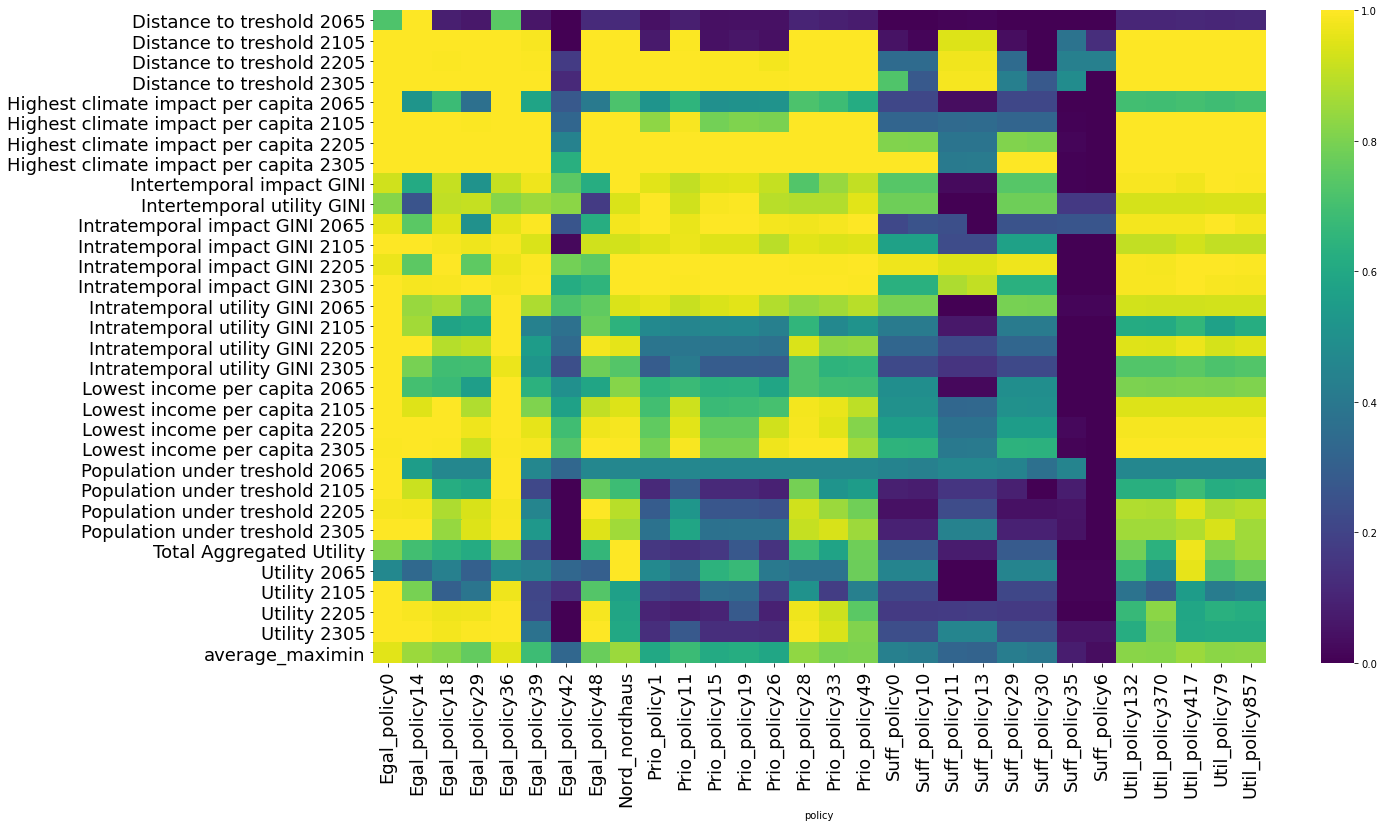

In [17]:
fig, ax = plt.subplots(figsize=(20,12))         
sns.heatmap(max_regret_min_max, cmap='viridis', annot=False,ax=ax)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)

fig.savefig('robustness_max_regret_long_term_heatmap_min_max_norm.png', dpi=200,bbox_inches='tight')
plt.show()

## Plot snr vs regret 

In [18]:
scatter_df = pd.DataFrame()
scatter_df["average maximin"] = max_regret_min_max.loc["average_maximin"]
scatter_df["average snr"] = scores_min_max.loc["average_snr"]

scatter_df['principle'] =""

for i in scatter_df.index:
    principle = experiments[experiments['policy_recoded']==i]["principle"].unique() 
    scatter_df['principle'].loc[i] = principle[0]

C:\Users\ivart\anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


C:\Users\ivart\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ivart\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


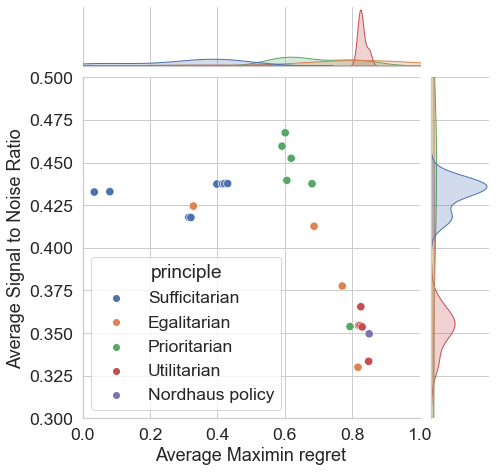

In [21]:
sns.set(font_scale=1.6)  # crazy big
sns.set_style("whitegrid")

#a4_dims = (8,8)
#fig, ax = pyplot.subplots(figsize=a4_dims)
#sns.scatterplot(data=scatter_df, x=scatter_df["average maximin"], y=scatter_df["average snr"],s=70,hue=scatter_df["principle"],ax=ax)
plot = sns.jointplot(height = 7,data=scatter_df, x="average maximin", 
              y="average snr", hue="principle",s=70)

plot.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

plot.ax_marg_x.set_xlim(0, 1)
plot.ax_marg_y.set_ylim(0.3, 0.5)
plot.set_axis_labels('Average Maximin regret', 'Average Signal to Noise Ratio', fontsize=18)

plot.savefig('Comparision_of_average_long_term_robustness_vs_max_regret.png',dpi = 200)


In [26]:
scatter_df = scatter_df.sort_values(['average maximin'],ascending=True)
scatter_df = scatter_df.sort_values(['average snr'],ascending=False)
scatter_df

,average maximin,average snr,principle
policy,,,
Egal_policy0,0.956404,0.563604,Egalitarian
Egal_policy36,0.953876,0.548893,Egalitarian
Egal_policy14,0.847926,0.538254,Egalitarian
Prio_policy1,0.601439,0.467455,Prioritarian
Prio_policy26,0.591973,0.459608,Prioritarian
Prio_policy19,0.619176,0.452510,Prioritarian
Prio_policy15,0.606354,0.439537,Prioritarian
Suff_policy0,0.430624,0.437679,Sufficitarian
Suff_policy29,0.421676,0.437609,Sufficitarian
